In [10]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline)

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [4]:
traindata = pd.read_csv('data/churn_train.csv')

In [6]:
traindata.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [7]:
traindata.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct'],
      dtype='object')

In [22]:
num_vars = traindata[['avg_dist', 'avg_rating_by_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']]

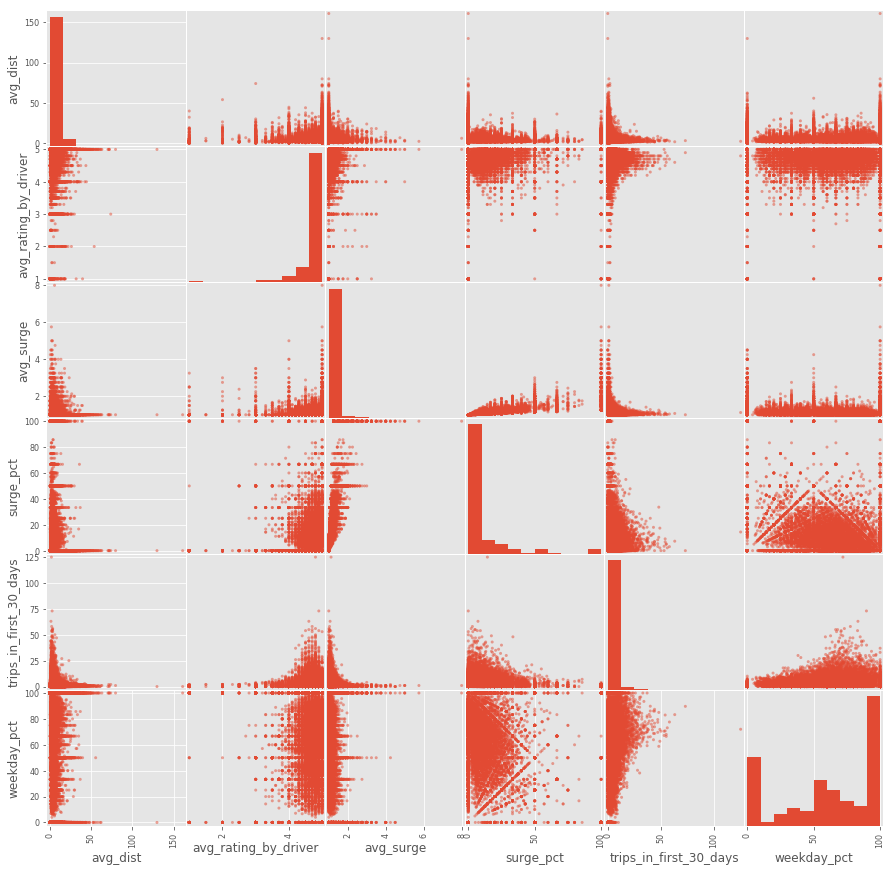

In [23]:
ax = scatter_matrix(num_vars, figsize=(15,15))



In [24]:
#sort NaNs

In [108]:
#def split_one(df,colum,value_to_split)
nandf = pd.DataFrame(traindata.avg_rating_of_driver)
#this makes the array trues and falses depending on if the value is NaN
maskdf = traindata.avg_rating_of_driver.isnull()
df['is_NaN'] = maskdf
df.drop('avg_rating_of_driver', axis = 1)
df.head()



,avg_rating_of_driver,is_NaN
0,5.0,False
1,5.0,False
2,NaN,True
3,NaN,True
4,NaN,True


In [119]:
mean = np.mean(nandf['avg_rating_of_driver'])
mean

4.601696940726505

In [120]:
nandf.fillna(mean).head()

,avg_rating_of_driver
0,5.000000
1,5.000000
2,4.601697
3,4.601697
4,4.601697


In [133]:
# this will change the NaNs to means for avg_rating_of_driver and avg_rating_by_driver
def NullsToMean(col):
    '''input: column with NaNs
        output: column with Means'''
    df = pd.DataFrame(traindata[col])
    #this makes the array trues and falses depending on if the value is NaN
    maskdf = traindata[col].isnull()
    df['is_NaN'] = maskdf
    return df.fillna(np.mean(df[col])).head() #df.drop(['avg_rating_of_driver'], axis = 1)
NullsToMean('avg_rating_of_driver')

,avg_rating_of_driver,is_NaN
0,5.000000,False
1,5.000000,False
2,4.601697,True
3,4.601697,True
4,4.601697,True


In [114]:



def null_fill_mean(x):
    y = x.copy()
    y[np.isnan(y)] = (np.mean(y[~np.isnan(y)]))

avg_rating_of_driver_fit = Pipeline(
    [('avg_rating_of_driver', ColumnSelector(name='avg_rating_of_driver')), 
     ('union', FeatureUnion([
         ('rate_of_driver_nan', MapFeature(lambda: x.astype(str) == 'NaN', 'rate_of_driver_nan')),
     ('rate_of_driver_filled', MapFeature(lambda x: null_fill_mean(x), 'rate_of_driver_filled')),
     ]))
    ])
avg_rating_of_driver_fit

Pipeline(memory=None,
     steps=[('avg_rating_of_driver', ColumnSelector(idxs=None, name='avg_rating_of_driver')), ('union', <regression_tools.dftransformers.FeatureUnion object at 0x1a2115dba8>)])

In [92]:
MachineHoursCurrentMeter_fit = Pipeline([
    ('MachineHoursCurrentMeter', ColumnSelector(name='MachineHoursCurrentMeter')),
    ('union', FeatureUnion([
        ('mh_nan', MapFeature(lambda x: x.astype(str) == 'nan', 'mh_nan')),
        ('mh_filled', MapFeature(lambda x: mh_fill_mean(x), 'mh_filled'))
    ]))
])

def SeperateNulls(col):
    #new_df = pd.DataFrame(df.columnname)
    maskdf = col.isnull()
    df['is_NaN'] = maskdf
    return col #df.drop(str(columnname), axis = 1)


In [56]:
def mh_fill_mean(x):
    y = x.copy()
    y[np.isnan(y)] = round(np.mean(y[~np.isnan(y)]), 0)
    return y

MachineHoursCurrentMeter_fit = Pipeline([
    ('MachineHoursCurrentMeter', ColumnSelector(name='MachineHoursCurrentMeter')),
    ('union', FeatureUnion([
        ('mh_nan', MapFeature(lambda x: x.astype(str) == 'nan', 'mh_nan')),
        ('mh_filled', MapFeature(lambda x: mh_fill_mean(x), 'mh_filled'))
    ]))
])

def split_one(df,column,value_to_split):
    '''
    input df : dataframe
        column : column to be split
        value_to_split: value to pull out to form a new column
    '''
    columndf = pd.DataFrame(df[column]).astype(np.int64)
    columnmask = df[column]==value_to_split
    columnname= str(column)
    column_spec_name= columnname +'_spec'
    column_split_name= columnname +'_is_' + str(value_to_split)
    columndf[column_spec_name] = columndf[column][columnmask==False].astype(np.int64)
    columndf[column_split_name] = columndf[column][columnmask==True].astype(np.int64)
    return columndf.drop(columnname, axis =1)

class DaysAgo():
    '''
    Transformer creates a days_ago feature for the last trip taken
    Start date is 7/1/2014, the day data was pulled
    In: The 'last_trip_date' feature as a datetime object
    Out: New feature 'days_ago' as an integer
    '''

    def __init__(self):
        # self.levels = None
        pass

    def fit(self):
        '''
        Does this need to do anything?
        '''
        return self

    def transform(self, dates):
        '''Create the new feature'''
        days_ago = max(dates) - dates
        days_ago = days_ago.apply(lambda x: x.days)
        return days_ago

In [57]:
def split_one(df,column,value_to_split):
    '''
    input df : dataframe
        column : column to be split
        value_to_split: value to pull out to form a new column
    '''
    columndf = pd.DataFrame(df[column]).astype(np.int64)
    columnmask = df[column]==value_to_split
    columnname= str(column)
    column_spec_name= columnname +'_spec'
    column_split_name= columnname +'_is_' + str(value_to_split)
    columndf[column_spec_name] = columndf[column][columnmask==False].astype(np.int64)
    columndf[column_split_name] = columndf[column][columnmask==True].astype(np.int64)
    return columndf.drop(columnname, axis =1)

In [67]:
split_one(traindata, traindata['avg_rating_of_driver'], 5.0)

KeyError: '[5.  5.  nan ... 5.  3.3 5. ] not in index'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder as onehot

# This is the start of our collection of functions and classes

#
# Transformer Classes
#
# Target -- Create both DaysAgo and Churned features
#
class DaysAgo():
    '''
    Transformer creates a days_ago feature for the last trip taken
    Start date is 7/1/2014, the day data was pulled
    In: The 'last_trip_date' feature as a datetime object
    Out: New feature 'days_ago' as an integer
    '''

    def __init__(self):
        # self.levels = None
        pass

    def fit(self):
        '''
        Does this need to do anything?
        '''
        return self

    def transform(self, dates):
        '''Create the new feature'''
        days_ago = max(dates) - dates
        days_ago = days_ago.apply(lambda x: x.days)
        return days_ago

class Churned():
    '''
    Transformer creates the target feature
    In: The 'last_trip_date' feature as a datetime object
    Out: New feature 'churned' as 1-0 data
    '''

    def __init__(self):
        # self.levels = None
        pass

    def fit(self):
        '''
        Does this need to do anything?
        '''
        return self

    def transform(self, dates):
        '''Create the new feature'''
        days_ago = max(dates) - dates
        days_ago = days_ago.apply(lambda x: x.days)
        return (days_ago > 30).astype(int)

#
# LuxuryBoolean
#
class LuxuryBoolean():
    '''
    Transformer makes 'luxury_car_user' a 0-1 integer
    In: The 'luxury_car_user' feature boolean object
    Out: New feature 'is_luxury_user' as 1-0 data
    '''

    def __init__(self):
        # self.levels = None
        pass

    def fit(self):
        '''
        Does this need to do anything?
        '''
        return self

    def transform(self, bool):
        '''Create the new feature'''
        lux = bool.apply(lambda x: x is True).astype(int)
        return lux

#
# Total miles
#
class MilesPer30Days():
    """Transformer Class
            Input:
                [DataFrame] [['trips_in_first_30_days', 'avg_dist']]
            Calculation:
                trips_in_first_30_days * average_distance
            Returns:
                [DataFrame] ['miles_per_30d']
    """
    def __init__(self):
        return None

    def fit(self):
        return self

    def transform(self, dataframe):
        # [DataFrame] [['trips_in_first_30_days', 'avg_dist']]
        df_copy = dataframe.copy()
        df_miles_per_30d = df_copy['trips_in_first_30_days'] * df_copy['avg_dist']
        return df_miles_per_30d

#
# NaNs
#
# Phone
#
class PhoneNan():
    '''
    Transformer makes 'phone' a group of one-hot features
    In: The 'phone' feature categorical object (396 NaNs)
    Out: New features to be named 'phone_is_nan', 'phone_is_android', 'phone_is_apple'
    '''

    def __init__(self):
        # self.levels = None
        pass

    def fit(self):
        '''
        Does this need to do anything?
        '''
        return self

    def transform(self, phn):
        '''Create the new feature'''
        nan = phn.isna().astype(int)
        android = (phn == 'Android').astype(int)
        apple = (phn == 'iPhone').astype(int)
        return nan, android, apple


# This is Alex's test

### Steven's log loss function  ########

def log_loss_score( y_hats, y_act):
    return -np.sum(  ( ((y_act) * np.log (1 + y_hats)) + (( 1 - y_act) * np.log (1 + y_hats)   )  )) / (len(y_hats))